### Testing unsupervised learning on spectral unmixing
I wanted to recreate [this paper's](https://pubmed.ncbi.nlm.nih.gov/31790435/) novel method for unmixing multiple sources of fluorescence in microscopy. I have performed this work in the "traditional" way of assuming a linear mixing model, calibrating, and using a least squares method to find best guesses for endmembers. This method suffers from the need to calibrate and know all possible noise sources before hand, and does not alow for the shifts in spectra commonly seen.

This code:

    1) Loads 2 data sets from different sources
    2) Restructure the data into data frame with key features:
        * Spectra
        * Average intensity within filter bandwidth
        * Class
    3) Explores the data in interactive plots
    4) Creates synthetic data by combining the datasets and adding noise
    5) Run clustering

In [4]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
import os
import cufflinks as cf
import plotly.offline
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#### Load 2 data sets, one with spectra, one with underlying noise

* Load the data
* Cut out wavelength not needed
* Resample to a standard wavelength spacing

In [5]:
filepath = r'/Users/maureenkeenan/Documents/InnerPlant Spectra'
fileSpectra = r'Fluorophore Emission Spectra.xlsx'
fileBackground = r'Wild Type Leaf Reflectance.xlsx'
dfSignal = pd.read_excel(os.path.join(filepath,fileSpectra))
dfBg = pd.read_excel(os.path.join(filepath,fileBackground))

In [6]:
dfPlot = dfSignal.set_index('Wavelengths')
dfPlot = dfPlot.truncate(before=350, after=899.9)
dfPlot.iplot()

In [7]:
dfBg.head()

Wavelengths     Control_1     Control_2     Control_3     Control_4  \
0   339.016140     18.343196     18.343196     18.343196     18.343196   
1   339.396721  28885.293490  28885.293490  28885.293490  28885.293490   
2   339.777263   2332.206406   2334.826862   2387.235995   2303.381383   
3   340.157764   2337.447319   2416.061018   2308.622296   2298.140469   
4   340.538226   2256.213163   2282.417730   2274.556360   2219.526770   

      Control_5  
0     18.343196  
1  28885.293490  
2   2190.701747  
3   2256.213163  
4   2203.804031

In [8]:
newindex = np.arange(350, 900, 0.1) 
oldindex = dfBg.Wavelengths

(r,c) = dfBg.shape
newBg = pd.Series(newindex)
for i in np.arange(1,c):
    test = np.interp(newindex,dfBg.Wavelengths, dfBg.iloc[:,i].values)
    newBg = pd.concat([newBg,pd.Series(test)], axis = 1)
   
newBg.columns = dfBg.columns.tolist()

newBgPlot = newBg.set_index('Wavelengths')
newBgPlot.iplot()

#### Create combinations of data
Signal be 0.1 - 2% of peak signal of control

Start by adding 1% of fluorophore to each control

In [13]:
def addSpectra(spectraPercent, spectraName):
    scaledDf = pd.DataFrame()
    for n in range(len(spectraPercent)):
        scaleFactor = spectraPercent[n]*newBgPlot.max()
        spectraValues = dfPlot[spectraName].values
        name = str(spectraName+'_' + str(spectraPercent[n]))

        for i in range(len(scaleFactor)):
            scaledFl = np.multiply(spectraValues,scaleFactor[i])
            noise = np.random.normal(0,10,len(scaledFl))
            scaled   = newBgPlot.iloc[:,i] + scaledFl + noise
            colName = str(name +'_'+str(i+1))
            scaledDf[colName] = scaled
        
    return scaledDf

In [54]:
fl = np.array([0,.001,0.01,0.05,0.1,1])
red = addSpectra(fl, "tdTomato")
green = addSpectra(fl, "GFP")
yellow = addSpectra(fl, "mVenus")
df = pd.concat([red,green,yellow], axis = 1)
df.head()

tdTomato_0.0_1  tdTomato_0.0_2  tdTomato_0.0_3  tdTomato_0.0_4  \
Wavelengths                                                                   
350.0           2671.382156     3164.455670     2767.181172     2609.525999   
350.1           2687.002627     3161.132938     2767.001068     2611.986995   
350.2           2720.081546     3158.849081     2762.940567     2629.696792   
350.3           2749.336237     3155.561917     2762.285227     2648.754116   
350.4           2780.005727     3153.731822     2758.863112     2668.524949   

             tdTomato_0.0_5  tdTomato_0.001_1  tdTomato_0.001_2  \
Wavelengths                                                       
350.0           2905.187092       2670.576859       3162.863205   
350.1           2917.903770       2688.561551       3160.926196   
350.2           2935.115100       2716.796949       3158.618063   
350.3           2948.965496       2750.195185       3154.283939   
350.4           2967.044481       2778.791062       3152.772087   

             tdTomato_0.001_3  tdTomato_0.001_4  tdTomato_0.001_5  \
Wavelengths                                                         
350.0             2767.231147       2609.200845       2907.735566   
350.1             2765.281702       2610.470370       2916.964133   
350.2             2764.807952       2629.147958       2934.461391   
350.3             2761.086292       2649.849629       2950.169480   
350.4             2761.924892       2665.487692       2965.870244   

                 ...       mVenus_0.1_1  mVenus_0.1_2  mVenus_0.1_3  \
Wavelengths      ...                                                  
350.0            ...        2672.023233   3162.197150   2769.617081   
350.1            ...        2687.423183   3162.152870   2765.786056   
350.2            ...        2718.340844   3158.578736   2763.891553   
350.3            ...        2748.179574   3156.105008   2760.002003   
350.4            ...        2780.325639   3151.406263   2760.391675   

             mVenus_0.1_4  mVenus_0.1_5  mVenus_1.0_1  mVenus_1.0_2  \
Wavelengths                                                           
350.0         2610.034267   2908.324985   2670.426163   3161.781339   
350.1         2611.623951   2919.090280   2686.707669   3160.536768   
350.2         2630.581717   2934.242505   2718.427992   3158.314332   
350.3         2647.977589   2951.231343   2749.065664   3154.991554   
350.4         2668.259899   2966.536140   2780.483590   3151.518584   

             mVenus_1.0_3  mVenus_1.0_4  mVenus_1.0_5  
Wavelengths                                            
350.0         2766.937132   2609.380054   2906.324883  
350.1         2766.087918   2611.758715   2918.712607  
350.2         2763.214993   2629.565226   2932.700345  
350.3         2762.610739   2649.602958   2948.961378  
350.4         2759.248487   2666.077569   2967.752529  

[5 rows x 90 columns]

#### Pull out relevant features based on filter widths:
<br>
QEPRO: 500 - 600nm
<br>
  GFP: 502 - 538nm
  <br>
DSRED: 576 - 596nm
<br>
 BASE: 620 -640nm

In [55]:
import re
column_names = ['Class','Intensity','Spectra','QEPro','Green','Yellow','Red','Base']
data = pd.DataFrame(columns = column_names)

# Define wavelength ranges
wavRange   = np.where(np.logical_and(df.index>=450, df.index<=650))
QEProRange = np.where(np.logical_and(df.index>=500, df.index<=600))

# Filters
greenRange  = np.where(np.logical_and(df.index>=500, df.index<=515))
yellowRange = np.where(np.logical_and(df.index>=525, df.index<=540))
redRange    = np.where(np.logical_and(df.index>=576, df.index<=596))
baseRange   = np.where(np.logical_and(df.index>=620, df.index<=640))


In [56]:
# Sort and transform the data
for i in range(len(df.columns)):
    txt = df.columns[i]
    
    # Pull out intensity info
    spectra = pd.Series(df[txt].iloc[wavRange])
    qepro   = pd.Series(df[txt].iloc[QEProRange])
    
    # Get average intensities
    greenMean    = df[txt].iloc[greenRange].mean()
    yellowMean   = df[txt].iloc[yellowRange].mean()
    redMean      = df[txt].iloc[redRange].mean()
    baseMean     = df[txt].iloc[baseRange].mean()
    
    # Add classification to dataframe for later
    fl = txt.split('_')[0]
    intensity = txt.split('_')[1]
    if float(intensity) == 0:
        fl = 'control'
        
    data = data.append({'Spectra': spectra, 'Class': fl,'Intensity': intensity, 
                        'QEPro': qepro, 'Green': greenMean, 'Yellow': yellowMean,'Red': redMean, 'Base': baseMean}, ignore_index=True)
            

#### Create new features based on ratios of old features
This is intended to capture the rise of the desired channel and normalize out changes in lighting or or sample, by dividing by a "base" which should be empty of any fluorophore

In [57]:
data['greenBase'] = data.Green/data.Base
data['yellowBase'] = data.Yellow/data.Base
data['redBase'] = data.Red/data.Base

#### Look at the data

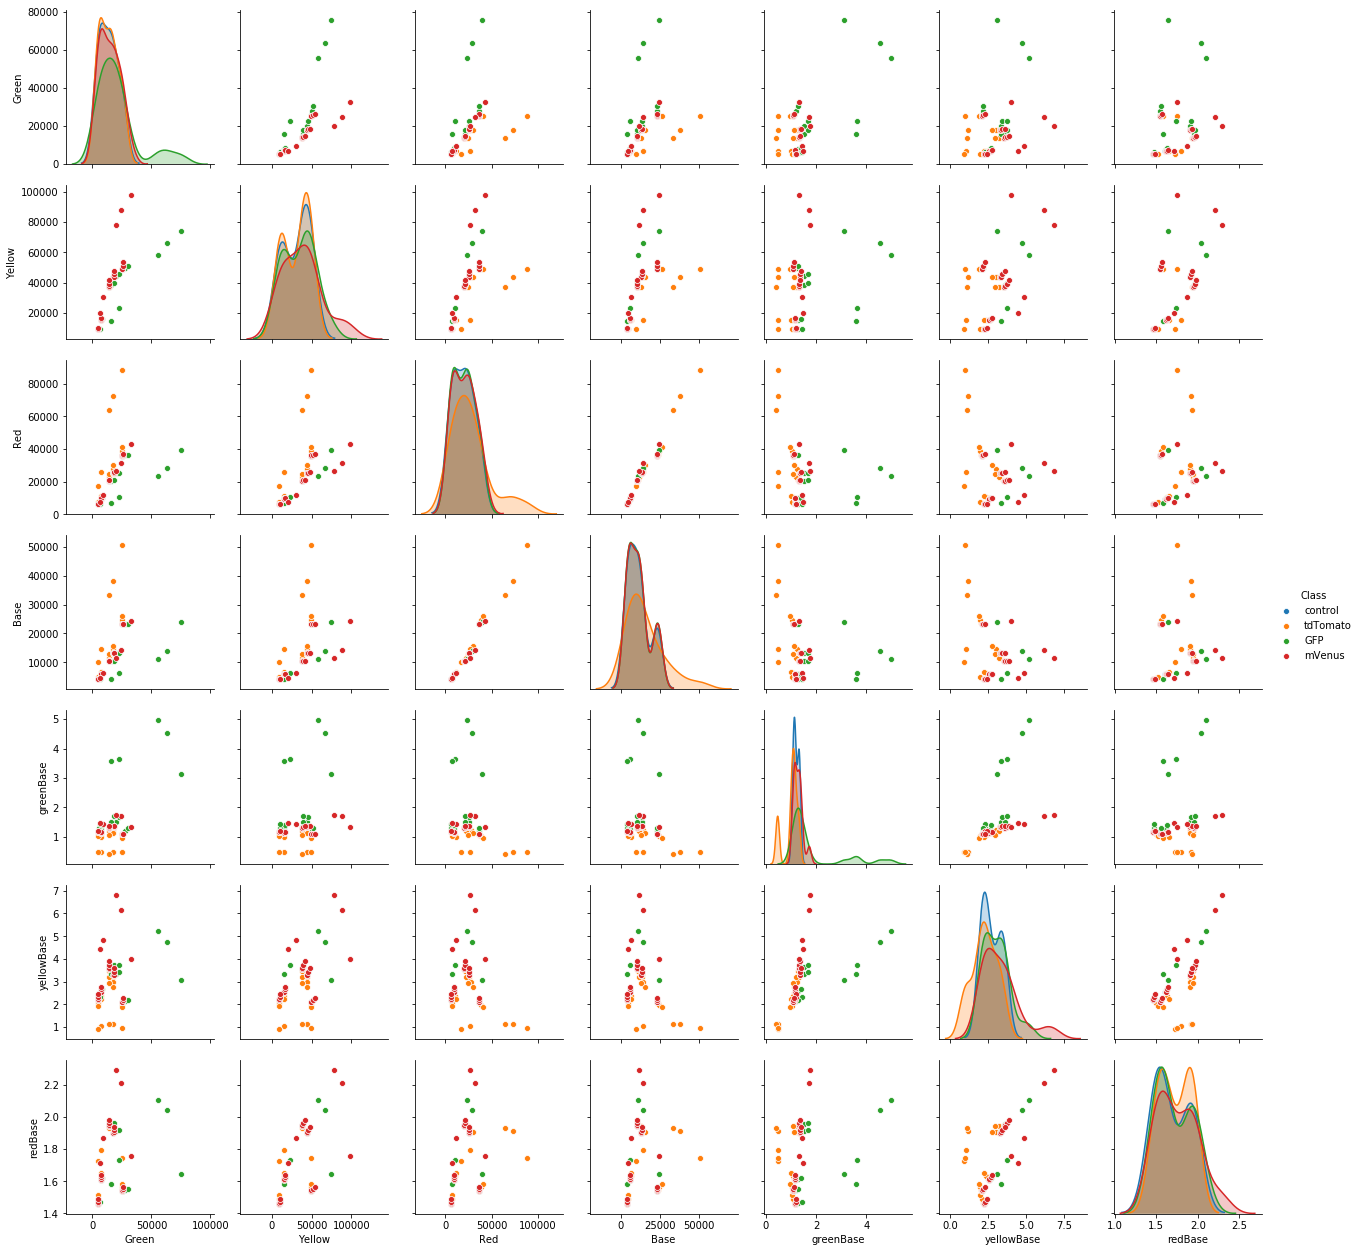

In [58]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#features = ['yellowBase','greenBase','redBase','Class','Base']
#filtered_data = data[features]
filtered_data = data.drop(columns=['Intensity','Spectra','QEPro'])
pp = sns.pairplot(filtered_data, hue="Class")
fig = pp.fig


#### Check out what the clustering algorithm says is there

This is already a known quantity - there are 4 clusters in the data. One for each of the 3 fluorophores I added, plus the control, which had only noise added to it. <br> Check anyway to compare to the paper

Text(0, 0.5, 'Distortion')

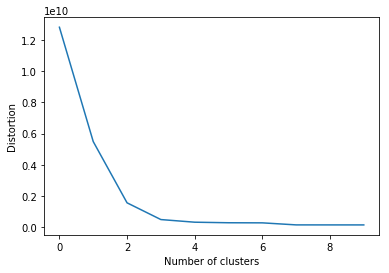

In [105]:
from sklearn.cluster import KMeans
features = ['Green','greenBase']
data_toCluster = data[features]

distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(data_toCluster)
    distortions.append(km.inertia_)

plt.plot(distortions)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')


In [ ]:
def fitClusters(n):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(data_toCluster)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    return labels,centroids

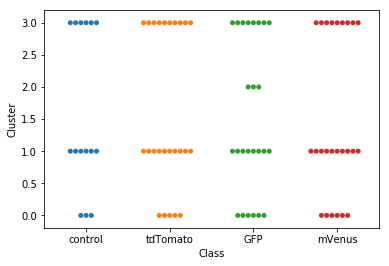

In [106]:
[labels, centroids] = fitClusters(4)

results = pd.DataFrame(np.column_stack((data.Class,labels)), columns=["Class","Cluster"])
results.head()
sns.swarmplot(x="Class", y="Cluster", data=results)

#### SVM in Andrew Ng's course looked useful

Next steps, re-examine using greenBase as a feature and build a support vector machine classifier. 
<br>
Consider: 
<br>
one-vs-all and 

In [ ]:
from sklearn.svm import SVC


clf = SVC(gamma='auto')
clf.fit(X, y)
SVC(gamma='auto')
print(clf.predict([[-0.8, -1]]))